In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import numpy as np
from scipy import stats
import gseapy as gp
from gseapy import barplot, dotplot
import seaborn as sns
import matplotlib.pyplot as plt
import PyComplexHeatmap as pch
from PyComplexHeatmap import *

plt.rcParams['figure.dpi'] = 200
plt.rcParams['savefig.dpi']=300
plt.rcParams['pdf.fonttype']=42

In [2]:
def filter_terms(terms):
    term_dict = {}
    for term in terms:
        first_word = term.split()[0]
        if first_word not in term_dict:
            term_dict[first_word] = term
    return list(term_dict.values())


## GO

In [3]:
_gender = 'Male'
mc_type = 'CGN'
ct_type = 'All_CellType'

In [4]:
gene_name_to_id = joblib.load('/home/qzeng/project/aging/240112_DMG_CEF/gene_name_to_id_dict')
gene_id_to_name = joblib.load('/home/qzeng/project/aging/240112_DMG_CEF/gene_id_to_name_dict')

gene_meta_path = '/home/qzeng/project/aging/metadata/gencode.vM22.basic.annotation.gene.flat.tsv.gz'
gene_meta = pd.read_csv(gene_meta_path, index_col ='gene_id', sep='\t')
gene_meta['length'] = gene_meta['end'] - gene_meta['start']
gene_length_dict = gene_meta['length'].to_dict()

In [5]:
_dir = '/home/qzeng/project/aging/240112_DMG_CEF'
mc_all = pd.read_csv(f'{_dir}/result/{_gender}.{mc_type}.DMG.csv', index_col = 0)
mc_all['celltype'] = mc_all['celltype'].apply(lambda x: x.replace('/','').replace(' ','_'))

/home/qz/miniconda3/envs/allcools/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3552: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [6]:
use_cts= joblib.load('mc_rna_corr_cts')
if ct_type == 'Neuron':
    use_cts = [ct for ct in use_cts if ct.endswith('NN') == False]
elif ct_type == 'NN':
    use_cts = [ct for ct in use_cts if ct.endswith('NN') == True]
if ct_type == 'All_CellType':
    use_cts= joblib.load('mc_rna_corr_cts')

In [7]:
_type = 'DEG'
pvalue_cutoff = 0.05
fc_cutoff = 0.1

In [8]:
ct_up_genes = {}
ct_down_genes = {}

for ct in use_cts:
    rna_df = pd.read_csv(f"DEGs/{ct}.csv", index_col = 0)
    rna_df['log2(Aged/Young)'] = -rna_df['avg_log2FC']
    deg_df = rna_df[(rna_df['p_val_adj'] < pvalue_cutoff) & (abs(rna_df['log2(Aged/Young)']) > fc_cutoff)]
    
    up_genes = deg_df[deg_df['log2(Aged/Young)'] > 0].index
    down_genes = deg_df[deg_df['log2(Aged/Young)'] < 0].index
    
    # get DEG mc info
    mc_df  = mc_all[mc_all['celltype'] == ct].copy()
    mc_df['gene_name'] = mc_df.index.map(gene_id_to_name)

    deg_mc_df = mc_df.set_index('gene_name')
    deg_mc_df = deg_mc_df.loc[deg_mc_df.index.isin(deg_df.index)]
    deg_mc_df['Aged-Young'] = deg_mc_df['18mo'] - deg_mc_df['8wk']
    
    
    # also filter for DMGs
    deg_mc_df  = deg_mc_df[deg_mc_df['pvalue'] < 0.05]
    mc_hyper_genes = deg_mc_df[deg_mc_df['Aged-Young'] > 0].index
    mc_hypo_genes = deg_mc_df[deg_mc_df['Aged-Young'] < 0].index
    
    # unique_genes = deg_mc_df.index.value_counts()[deg_mc_df.index.value_counts() == 1].index
    up_genes = list(set(mc_hypo_genes) & set(up_genes))
    down_genes = list(set(mc_hyper_genes) & set(down_genes))
    
    ct_up_genes[ct] = up_genes
    ct_down_genes[ct]  = down_genes

In [9]:
#mouse = gp.get_library_name(organism='mouse')

In [10]:
gene_sets = [
              'KEGG_2019_Mouse',
              'GO_Biological_Process_2023', 
              'GO_Molecular_Function_2023',
              #'WikiPathways_2019_Mouse',
              #'Reactome_2022'
               ]

In [17]:
for ct, gene_list in ct_up_genes.items():
    print(f"{ct}:{len(gene_list)}")
    if len(gene_list) > 10:
        go_enrichment = gp.enrichr(gene_list=gene_list,
                               gene_sets=gene_sets,
                               organism='mouse', # don't forget to set organism
                               #outdir='test/go', # set the output directory
                               no_plot=False, # do not draw a plot
                               cutoff=0.05) # set a significance cutoff
        try:
            result_df= go_enrichment.results
            result_df.to_csv(f'GO_result_by_celltype/{ct}.Up.enrichr.result.csv')
        except:
            continue

Microglia_NN:229
Oligo_NN:477
Astro-NT_NN:12
STR-PAL_Chst9_Gaba:203
L5_ET_CTX_Glut:36
Lamp5_Gaba:1
DG_Glut:164
L6_CT_CTX_Glut:66
Sst_Gaba:11
Astro-TE_NN:68
SUB-ProS_Glut:3
Vip_Gaba:0
CA1-ProS_Glut:238
STR_D1_Sema5a_Gaba:232
OPC_NN:69
LA-BLA-BMA-PA_Glut:27
L5_IT_CTX_Glut:40
L23_IT_ENT_Glut:68
CA3_Glut:137
L6bCT_ENT_Glut:57
Pvalb_Gaba:11
L5_NP_CTX_Glut:8
L6_IT_CTX_Glut:10
MEA-BST_Gaba:26
L23_IT_CTX_Glut:99
L23_IT_PPP_Glut:134
CEA-BST_Gaba:37


In [24]:
for ct, gene_list in ct_down_genes.items():
    print(f"{ct}:{len(gene_list)}")
    if len(gene_list) > 10:
        go_enrichment = gp.enrichr(gene_list=gene_list,
                               gene_sets=gene_sets,
                               organism='mouse', # don't forget to set organism
                               #outdir='test/go', # set the output directory
                               no_plot=False, # do not draw a plot
                               cutoff=0.05) # set a significance cutoff
        try:
            result_df= go_enrichment.results
            result_df.to_csv(f'GO_result_by_celltype/{ct}.Down.enrichr.result.csv')
        except:
            continue
     

Microglia_NN:34
Oligo_NN:540
Astro-NT_NN:10
STR-PAL_Chst9_Gaba:18
L5_ET_CTX_Glut:117
Lamp5_Gaba:1
DG_Glut:2398
L6_CT_CTX_Glut:568
Sst_Gaba:37
Astro-TE_NN:49
SUB-ProS_Glut:13
Vip_Gaba:1
CA1-ProS_Glut:464
STR_D1_Sema5a_Gaba:666
OPC_NN:38
LA-BLA-BMA-PA_Glut:26
L5_IT_CTX_Glut:347
L23_IT_ENT_Glut:32
CA3_Glut:212
L6bCT_ENT_Glut:81
Pvalb_Gaba:24
L5_NP_CTX_Glut:67
L6_IT_CTX_Glut:36
MEA-BST_Gaba:2
L23_IT_CTX_Glut:522
L23_IT_PPP_Glut:47
CEA-BST_Gaba:25


## plot

In [3]:
import glob
all_files = glob.glob(f'GO_result_by_celltype/*.Down.enrichr.result.csv')
all_files[:3]

['GO_result_by_celltype/Microglia_NN.Down.enrichr.result.csv',
 'GO_result_by_celltype/Oligo_NN.Down.enrichr.result.csv',
 'GO_result_by_celltype/STR-PAL_Chst9_Gaba.Down.enrichr.result.csv']

In [4]:
#result_df = pd.read_csv('GO_result_by_celltype/Microglia_NN.Down.enrichr.result.csv', index_col =0)

In [46]:
all_result_df = []

for fp in all_files:
    result_df = pd.read_csv(fp, index_col =0)
    result_df['gene_num'] = result_df['Overlap'].apply(lambda x: int(x.split('/')[0]))
    #result_df = result_df[(result_df['Adjusted P-value']  < 0.05) & (result_df['gene_num']  > 15)]
    result_df = result_df[(result_df['Adjusted P-value']  < 1e-3) & (result_df['gene_num']  > 5)]
    result_df['CellType'] = fp.split('/')[-1].split('.')[0]
    all_result_df.append(result_df)

all_result_df = pd.concat(all_result_df, axis = 0)
all_result_df['-log10(p)'] = -np.log10(all_result_df['P-value'])
all_result_df.sort_values('Adjusted P-value').head()

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes,gene_num,CellType,-log10(p)
222,GO_Biological_Process_2023,Cytoplasmic Translation (GO:0002181),75/93,9.612404e-95,2.335814e-91,0,0,136.181613,29480.940074,EIF4A2;RPL4;EIF4A1;RPL5;RPL30;RPL3;RPL32;RPL31...,75,STR_D1_Sema5a_Gaba,94.017168
228,GO_Biological_Process_2023,Cytoplasmic Translation (GO:0002181),68/93,4.809691e-87,1.008592e-83,0,0,111.998305,22260.141398,EIF4A2;RPL4;EIF4A1;RPL5;RPL30;RPL3;RPL32;RPL31...,68,Oligo_NN,86.317883
223,GO_Biological_Process_2023,Peptide Biosynthetic Process (GO:0043043),78/158,1.262240e-72,1.533622e-69,0,0,31.926276,5285.498306,RPL4;RPL5;RPL30;RPL3;RPL32;RPL31;RPL34;RPLP1;M...,78,STR_D1_Sema5a_Gaba,71.898858
224,GO_Biological_Process_2023,Macromolecule Biosynthetic Process (GO:0009059),82/183,6.120357e-72,4.957489e-69,0,0,26.737861,4384.327574,RPL4;RPL5;RPL30;RPL3;RPL32;RPL31;RPL34;RPLP1;M...,82,STR_D1_Sema5a_Gaba,71.213223
0,KEGG_2019_Mouse,Ribosome,78/170,1.993947e-69,4.426562e-67,0,0,27.744676,4388.881914,RPL4;RPL5;RPL30;RPL3;RPL32;RPL31;RPL34;RPLP1;M...,78,STR_D1_Sema5a_Gaba,68.700286


In [47]:
all_result_df['Gene_set'].value_counts()

GO_Biological_Process_2023    185
KEGG_2019_Mouse                78
GO_Molecular_Function_2023     55
Name: Gene_set, dtype: int64

In [48]:
all_gene_sets = ['GO_Biological_Process_2023','GO_Molecular_Function_2023', 'KEGG_2019_Mouse']

In [49]:
hue_dict = {'GO_Biological_Process_2023':(10,60),
            'GO_Molecular_Function_2023':(10,50),
            'KEGG_2019_Mouse':(5,50)}

size_dict = {'GO_Biological_Process_2023':(30,100),
            'GO_Molecular_Function_2023':(60,200),
            'KEGG_2019_Mouse':(60,200)}

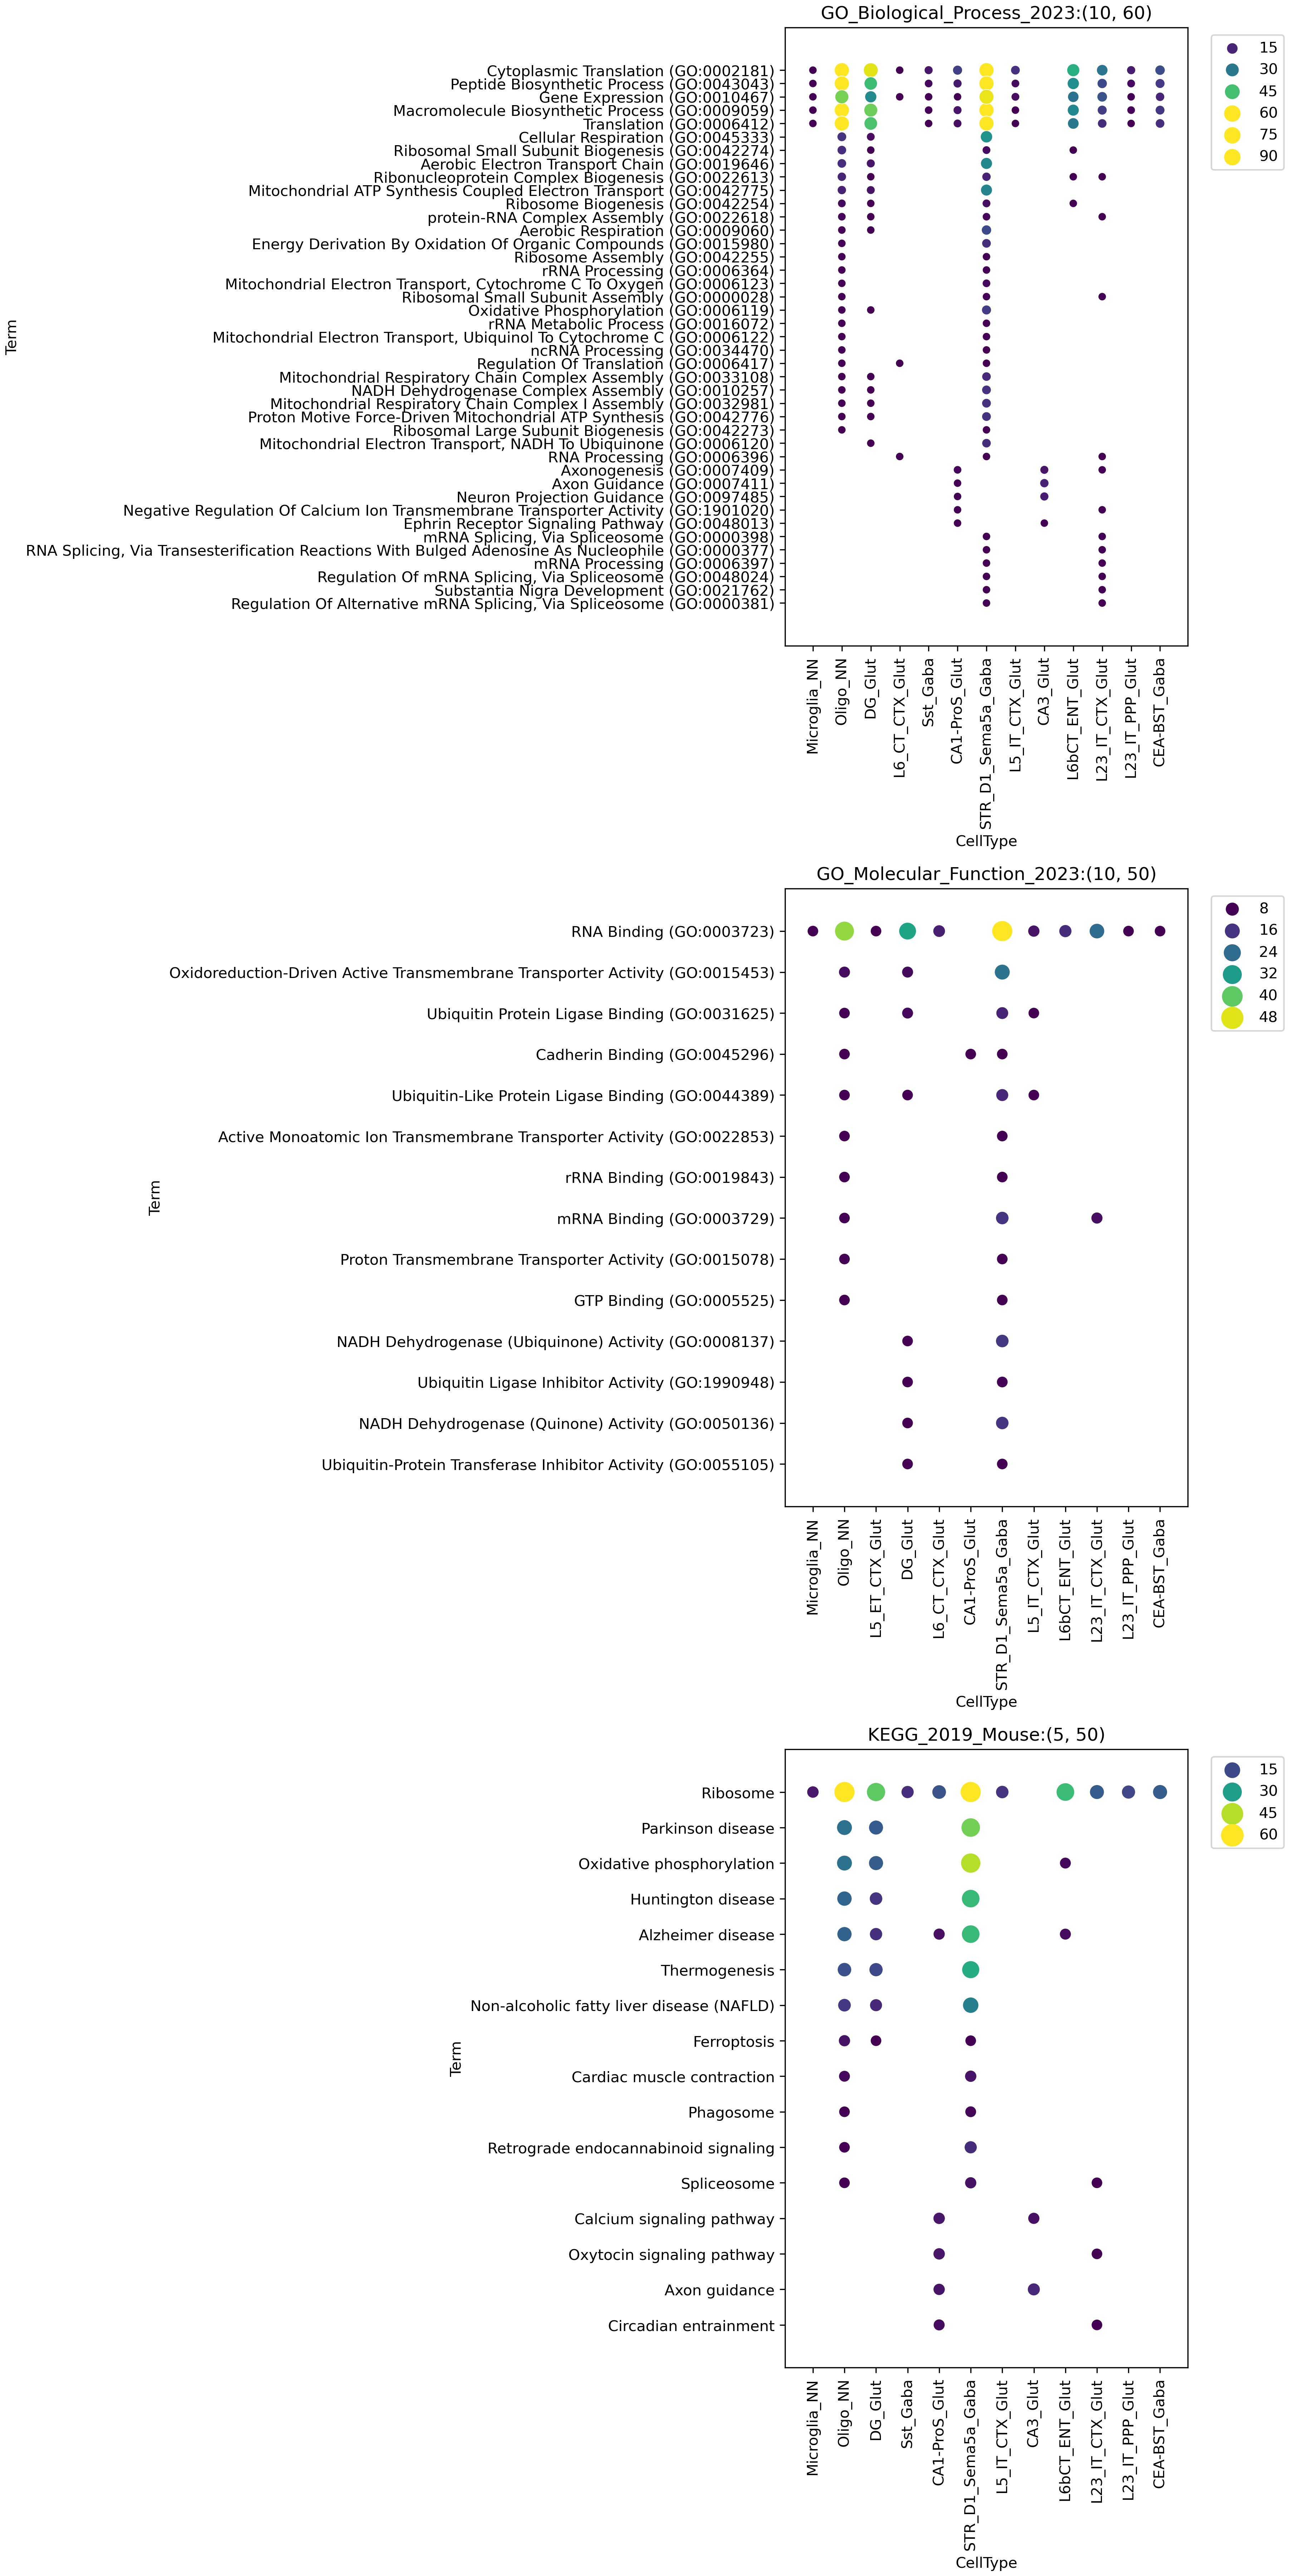

In [50]:
fig, axes = plt.subplots(figsize=(12,24),nrows = 3, dpi = 300, constrained_layout = True)

for gene_set, ax in zip(all_gene_sets, axes.ravel()):
    plot_df = all_result_df[all_result_df['Gene_set'] == gene_set].copy()
    plot_df = plot_df[['Term','CellType','-log10(p)']]

    term_counts = plot_df['Term'].value_counts()
    use_terms = term_counts[term_counts >= 2].index
    plot_df = plot_df[plot_df['Term'].isin(use_terms)]
    norm = hue_dict[gene_set]
    
    ax = sns.scatterplot(data=plot_df, 
                         x='CellType', 
                         y='Term', 
                         size='-log10(p)', 
                         hue='-log10(p)', 
                         hue_norm = norm,
                         ax=ax, 
                         sizes=size_dict[gene_set],
                         size_norm = norm,
                         palette = 'viridis'
                        )
    ax.legend(bbox_to_anchor=(1.04,1), loc="upper left")
    ax.margins(0.08)  # You can adjust this value as per your requirement
    plt.setp(ax.get_xticklabels(), rotation=90)
    ax.set_title(f"{gene_set}:{norm}")

fig.savefig(f"figure/GO_by_celltype.pdf",bbox_inches="tight", dpi=300)
plt.show()

In [69]:
# use_terms = ['Ribosome', 'Alzheimer disease', 'Oxidative phosphorylation',
#        'Spliceosome', 'Huntington disease', 'Thermogenesis',
#         'Ferroptosis',
#        'Parkinson disease', 'Oxytocin signaling pathway',
#        'Calcium signaling pathway', 'Circadian entrainment', 'Axon guidance',
#        'Retrograde endocannabinoid signaling', 'Phagosome',
#        ]

## make barplot

In [34]:
all_result_df = []

for fp in all_files:
    result_df = pd.read_csv(fp, index_col =0)
    result_df['gene_num'] = result_df['Overlap'].apply(lambda x: int(x.split('/')[0]))
    result_df = result_df[(result_df['Adjusted P-value']  < 0.05) & (result_df['gene_num']  > 5)]
    #result_df = result_df[(result_df['Adjusted P-value']  < 1e-3) & (result_df['gene_num']  > 5)]
    result_df['CellType'] = fp.split('/')[-1].split('.')[0]
    all_result_df.append(result_df)

all_result_df = pd.concat(all_result_df, axis = 0)
all_result_df['-log10(p)'] = -np.log10(all_result_df['P-value'])
all_result_df.sort_values('Adjusted P-value').head()

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes,gene_num,CellType,-log10(p)
222,GO_Biological_Process_2023,Cytoplasmic Translation (GO:0002181),75/93,9.612404e-95,2.335814e-91,0,0,136.181613,29480.940074,EIF4A2;RPL4;EIF4A1;RPL5;RPL30;RPL3;RPL32;RPL31...,75,STR_D1_Sema5a_Gaba,94.017168
228,GO_Biological_Process_2023,Cytoplasmic Translation (GO:0002181),68/93,4.809691e-87,1.008592e-83,0,0,111.998305,22260.141398,EIF4A2;RPL4;EIF4A1;RPL5;RPL30;RPL3;RPL32;RPL31...,68,Oligo_NN,86.317883
223,GO_Biological_Process_2023,Peptide Biosynthetic Process (GO:0043043),78/158,1.262240e-72,1.533622e-69,0,0,31.926276,5285.498306,RPL4;RPL5;RPL30;RPL3;RPL32;RPL31;RPL34;RPLP1;M...,78,STR_D1_Sema5a_Gaba,71.898858
224,GO_Biological_Process_2023,Macromolecule Biosynthetic Process (GO:0009059),82/183,6.120357e-72,4.957489e-69,0,0,26.737861,4384.327574,RPL4;RPL5;RPL30;RPL3;RPL32;RPL31;RPL34;RPLP1;M...,82,STR_D1_Sema5a_Gaba,71.213223
0,KEGG_2019_Mouse,Ribosome,78/170,1.993947e-69,4.426562e-67,0,0,27.744676,4388.881914,RPL4;RPL5;RPL30;RPL3;RPL32;RPL31;RPL34;RPLP1;M...,78,STR_D1_Sema5a_Gaba,68.700286


In [35]:
plot_term = ['mRNA Binding (GO:0003729)',
             'Mitochondrial ATP Synthesis Coupled Electron Transport (GO:0042775)',
             'Axonogenesis (GO:0007409)',
             'Cadherin Binding (GO:0045296)',
             'Ubiquitin-Dependent Protein Catabolic Process (GO:0006511)',
             'mRNA Splicing, Via Spliceosome (GO:0000398)',
             'Ribonucleoprotein Complex Biogenesis (GO:0022613)',
             'Chromatin Remodeling (GO:0006338)']

In [40]:
for_bar_plot = all_result_df[all_result_df['Term'].isin(plot_term)].copy()
for_bar_plot = for_bar_plot[['Term','Adjusted P-value','Genes']]
for_bar_plot['-log10(FDR)'] = -np.log10(for_bar_plot['Adjusted P-value'])

# Sort the DataFrame by -log10(FDR)
for_bar_plot = for_bar_plot.sort_values(by='-log10(FDR)', ascending=False)


In [41]:
def format_gene(gene):
    return gene.capitalize()

In [42]:
use_for_bar_plot = []

for _term, tmpdf in for_bar_plot.groupby('Term'):
    tmpdf = tmpdf.sort_values('Adjusted P-value').head(1)
    use_for_bar_plot.append(tmpdf)
    

In [43]:
use_for_bar_plot = pd.concat(use_for_bar_plot)
use_for_bar_plot = use_for_bar_plot.sort_values('Adjusted P-value')
use_for_bar_plot

,Term,Adjusted P-value,Genes,-log10(FDR)
229,Mitochondrial ATP Synthesis Coupled Electron T...,9.126517e-31,NDUFB8;NDUFB7;NDUFB10;UQCRB;NDUFB5;COX4I1;NDUF...,30.039695
2655,mRNA Binding (GO:0003729),6.096774e-15,EIF4A1;RPL5;DDX5;CELF3;HNRNPU;RPL7;PURB;RPS14;...,14.214900
239,Ribonucleoprotein Complex Biogenesis (GO:0022613),1.886758e-13,RPL5;MRPS12;RPL11;RPL7;RPS15;RPS4X;RPS14;RPS16...,12.724284
180,Axonogenesis (GO:0007409),6.399071e-11,CYFIP2;SEMA5A;EPHA5;ROBO2;EPHA4;EPHA7;EPHA6;HS...,10.193883
2661,Cadherin Binding (GO:0045296),2.754479e-08,YWHAE;HSP90AB1;RPL34;ENO1;RPL6;RPL7A;PUF60;PCB...,7.559961
245,"mRNA Splicing, Via Spliceosome (GO:0000398)",2.220420e-07,SF3B5;SF3B2;DDX5;SF3B3;WBP4;HNRNPU;PNN;SNRPD2;...,6.653565
304,Ubiquitin-Dependent Protein Catabolic Process ...,3.269980e-05,UBXN2B;UBXN2A;UBE2D3;FBXO22;UBE2L3;RPGR;HERC3;...,4.485455
307,Chromatin Remodeling (GO:0006338),2.928607e-02,SETD2;CHTOP;RING1;ATRX;SMARCA5;CHD4;INO80;CTCF...,1.533339


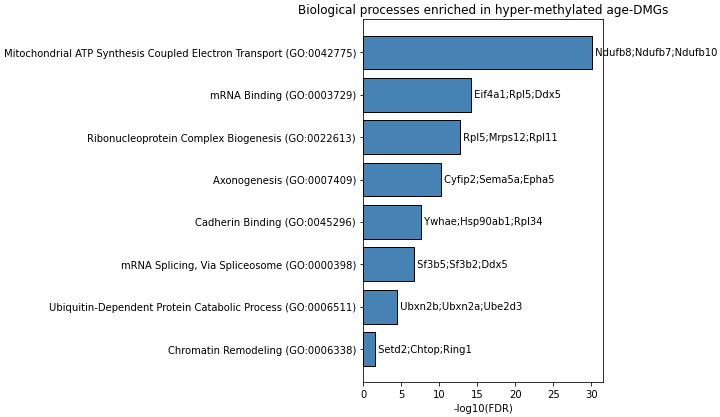

In [44]:
# Plot
plt.figure(figsize=(10, 6))
#plt.barh(for_bar_plot['Term'], for_bar_plot['-log10(FDR)'], color='steelblue', edgecolor='black')
# Annotate bars with the first 5 genes
bars = plt.barh(use_for_bar_plot['Term'], use_for_bar_plot['-log10(FDR)'], color='steelblue', edgecolor='black')

for i, (bar, genes) in enumerate(zip(bars, use_for_bar_plot['Genes'])):
    genes_list = genes.split(';')[:3]  # Get the first 5 genes
    annotation = ';'.join([format_gene(gene) for gene in genes_list])  # Format genes for the first bar
    
    plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2, f' {annotation}', va='center')

plt.xlabel('-log10(FDR)')
plt.xlabel('-log10(FDR)')
plt.title('Biological processes enriched in hyper-methylated age-DMGs')
plt.gca().invert_yaxis()  # Highest values at the top
plt.tight_layout()
#plt.savefig(f'figure/{group}.barplot.pdf', dpi=300)
plt.show()
